# Functions created for offline analysis

In [1]:
#1 is fake and 0 is real
#code authored by Aditya Tyagi and Suhas Dara
import os
import json
import pandas as pd
import math
import spacy
import numpy as np
import nltk
import random
import matplotlib.pyplot as plt 

In [2]:
image_labels = pd.read_csv("dataset_images/labels.csv")
video_labels = pd.read_csv("dataset_videos/labels.csv")

survey_data = pd.read_csv("worker_data/survey_data.csv", usecols=["code","age","races","gender","education","CRT1","CRT2","CRT3","AC1","AC2","AC3","AC4"])

In [3]:
def get_manifest_data():
    manifest_data = []
    
    name = "worker_data/iteration1/input1.manifest"
    with open(name) as file:
        manifest_data.extend(file.readlines())
    name = "worker_data/iteration2/input2.manifest"
    with open(name) as file:
        manifest_data.extend(file.readlines())
    
    return manifest_data

In [4]:
def get_json_data():
    json_data = []
    
    responses_dir = "worker_data/iteration1/worker_responses/"
    for filename in sorted(os.listdir(responses_dir)):
        with open(os.path.join(responses_dir, filename)) as file:
            json_data.append(json.load(file))
    responses_dir = "worker_data/iteration2/worker_responses/"
    for filename in sorted(os.listdir(responses_dir)):
        with open(os.path.join(responses_dir, filename)) as file:
            json_data.append(json.load(file))
    
    return json_data

In [5]:
def get_videorationale(response):
    return response["videorationale"]

In [6]:
def get_imagerationale(response):
    return response["imagerationale"]

In [7]:
def get_code(response):
    #returns the code from the worker response
    return int(response["code"])

In [8]:
def get_worker_id(worker_response):
    #returns the ID of worker from worker response
    return worker_response["workerId"]

In [9]:
def get_response_rows(worker_response, manifest_input):
    #returns new rows for dataframe [worker_id, code, image_num, video_num, label, annotation]
    response_rows = []
    
    element1 = manifest_input["source-ref"]
    element1 = element1[element1.rindex("/")+1:]
    element1_label = image_labels[image_labels["filename"]==element1]["label"].iloc[0]
   
    element2 = manifest_input["element2"]
    element2 = element2[element2.rindex("/")+1:]
    element2_label = image_labels[image_labels["filename"]==element2]["label"].iloc[0]
    
    element3 = manifest_input["element3"]
    element3 = element3[element3.rindex("/")+1:]
    element3_label = video_labels[video_labels["filename"]==element3]["label"].iloc[0]
    
    element4 = manifest_input["element4"]
    element4 = element4[element4.rindex("/")+1:]
    element4_label = video_labels[video_labels["filename"]==element4]["label"].iloc[0]
    
    worker_id = get_worker_id(worker_response)
    
    answer_content = worker_response["answerContent"]
    code = get_code(answer_content)
    if(answer_content["image1"]["real"]): #only check for real (0), if it is not then fake (1)
        response_rows.append([worker_id, code, int(element1.split(".")[0]), float('NaN'), element1_label, 0])
    else:
        response_rows.append([worker_id, code, int(element1.split(".")[0]), float('NaN'), element1_label, 1])
    if(answer_content["image2"]["real"]):
        response_rows.append([worker_id, code, int(element2.split(".")[0]), float('NaN'), element2_label, 0])
    else:
        response_rows.append([worker_id, code, int(element2.split(".")[0]), float('NaN'), element2_label, 1])
    if(answer_content["video1"]["real"]):
        response_rows.append([worker_id, code, float('NaN'), int(element3.split(".")[0]), element3_label, 0])
    else:
        response_rows.append([worker_id, code, float('NaN'), int(element3.split(".")[0]), element3_label, 1])
    if(answer_content["video2"]["real"]):
        response_rows.append([worker_id, code, float('NaN'), int(element4.split(".")[0]), element4_label, 0])
    else:
        response_rows.append([worker_id, code, float('NaN'), int(element4.split(".")[0]), element4_label, 1])

    return response_rows

In [10]:
def get_rationale_row(worker_response, manifest_input):
    #returns new rows for dataframe [worker_id, code, image1, image2, video1, video2, image_rat, video_rat]
    response_rows = []
    
    element1 = manifest_input["source-ref"]
    element1 = int(element1[element1.rindex("/")+1:element1.rindex(".")]) #convert the string to only the number
   
    element2 = manifest_input["element2"]
    element2 = int(element2[element2.rindex("/")+1:element2.rindex(".")]) #convert the string to only the number
    
    element3 = manifest_input["element3"]
    element3 = int(element3[element3.rindex("/")+1:element3.rindex(".")]) #convert the string to only the number
    
    element4 = manifest_input["element4"]
    element4 = int(element4[element4.rindex("/")+1:element4.rindex(".")]) #convert the string to only the number
    
    worker_id = get_worker_id(worker_response)
    
    answer_content = worker_response["answerContent"]
    code = get_code(answer_content)
    image = get_imagerationale(answer_content)
    video = get_videorationale(answer_content)
    
    return [worker_id, code, element1, element2, element3, element4, image, video]

# Looping through response here

In [11]:
def create_dataframes():
    manifest_data = get_manifest_data()
    json_data = get_json_data()
    
    df_anot = pd.DataFrame(columns=["workerId","code","image","video","label","annotation"])
    df_rat = pd.DataFrame(columns=["workerId","code","image1","image2","video1","video2","image_rat","video_rat"])
    
    for manifest_index in range(len(manifest_data)):
        manifest_input = json.loads(manifest_data[manifest_index])
        worker_responses = json_data[manifest_index]["answers"]
        
        for worker_response in worker_responses:
            response_rows = get_response_rows(worker_response, manifest_input)
            for row in response_rows:
                df_anot.loc[-1] = row
                df_anot.index = df_anot.index + 1
            
            rationale_row = get_rationale_row(worker_response, manifest_input)
            df_rat.loc[-1] = rationale_row
            df_rat.index = df_rat.index + 1
    
    return df_anot.sort_index(), df_rat.sort_index()

In [12]:
annotations, rationales = create_dataframes()

In [13]:
# remove duplicate survey data in annotations and rationales (multiple surveys same worker)
# change survey code in annotations to be 1-1 mapping for workerId and code

x = annotations.drop_duplicates(subset=['workerId'], keep='first')[['workerId', 'code']]
for index, row in x.iterrows():
    annotations.loc[annotations[annotations['workerId'] == row['workerId']].index, 'code'] = row['code']
    rationales.loc[rationales[rationales['workerId'] == row['workerId']].index, 'code'] = row['code']

survey_data = survey_data[survey_data['code'].isin(x['code'])].reset_index()

# eliminate bad responses with fake 5-digit code (no associated survey data)
bad_responses = set(annotations['code'].unique()).difference(set(survey_data['code'].unique()))
annotations = annotations[~annotations['code'].isin(bad_responses)].reset_index(drop=True)
rationales = rationales[~rationales['code'].isin(bad_responses)].reset_index(drop=True)

In [14]:
annotations

,workerId,code,image,video,label,annotation
0,public.us-east-1.A16QZSBYXE5VY8,63272,NaN,20,1,1
1,public.us-east-1.A16QZSBYXE5VY8,63272,NaN,18,0,0
2,public.us-east-1.A16QZSBYXE5VY8,63272,4,NaN,0,0
3,public.us-east-1.A16QZSBYXE5VY8,63272,26,NaN,1,1
4,public.us-east-1.A1VJMPRUU85JWR,74404,NaN,20,1,0
...,...,...,...,...,...,...
391,public.us-east-1.AJDPFPELWYQ7D,54907,9,NaN,0,0
392,public.us-east-1.A10Z4QVBJIA914,29558,NaN,11,0,0
393,public.us-east-1.A10Z4QVBJIA914,29558,NaN,24,1,1
394,public.us-east-1.A10Z4QVBJIA914,29558,8,NaN,0,0


In [15]:
rationales

,workerId,code,image1,image2,video1,video2,image_rat,video_rat
0,public.us-east-1.A16QZSBYXE5VY8,63272,26,4,18,20,Image #1 -> distortions in chin areas do not l...,1. Seems real. Saw no issues.\n2. Just maybe t...
1,public.us-east-1.A1VJMPRUU85JWR,74404,26,4,18,20,lighting and features of the face and skin\n,lighting and features of the face and skin\n
2,public.us-east-1.A3FPHDW608KQ4S,72923,26,4,18,20,I analyzed the pixel quality of the image to d...,I analyzed the movements of body gestures in c...
3,public.us-east-1.A3B0TDW8S89NSI,91126,26,4,18,20,The face on the first image is deformed on the...,The first video looks like the person only mak...
4,public.us-east-1.A10E2WR19C29IX,94221,26,4,18,20,"Image resolution, skin texture and tone, light...","video resolution, skin texture and tone, light..."
...,...,...,...,...,...,...,...,...
94,public.us-east-1.A16QZSBYXE5VY8,63272,9,8,24,11,"1. Sunglasses in really awkward position, mayb...",1. Face\n2. Seems real.
95,public.us-east-1.A3V4UX3FRT3KJU,26556,9,8,24,11,the texture of the skin,The sudden changes of the face
96,public.us-east-1.A36FBIDN58N139,46809,9,8,24,11,I didn't notice anything unusual.,In the first video the woman's face was glitch...
97,public.us-east-1.AJDPFPELWYQ7D,54907,9,8,24,11,The light reflection gives it away.,"The shadow on his face, along with the light t..."


In [16]:
survey_data

,index,age,races,gender,education,CRT1,AC1,AC2,AC3,AC4,CRT2,CRT3,code
0,1,40-49,Black or African American,Female,Undergraduate / Associates,1.05,NaN,NaN,3.0,NaN,100,13.0,53774
1,2,30-39,White,Male,High school,0.05,NaN,2.0,NaN,NaN,5,24.0,36810
2,3,30-39,White,Male,Masters / PhD,0.05,NaN,2.0,NaN,NaN,5,24.0,93210
3,4,40-49,White,Female,Undergraduate / Associates,5.00,NaN,NaN,NaN,4.0,5,24.0,29558
4,5,20-29,Asian,Male,Undergraduate / Associates,5.00,NaN,2.0,NaN,NaN,5,48.0,29716
5,9,20-29,White,Male,High school,0.05,NaN,2.0,NaN,NaN,5,24.0,46809
6,13,30-39,White,Male,Undergraduate / Associates,0.05,NaN,2.0,NaN,NaN,5,24.0,14687
7,14,40-49,White,Male,Undergraduate / Associates,0.10,NaN,NaN,NaN,4.0,100,12.5,54907
8,16,30-39,Black or African American,Male,Undergraduate / Associates,0.10,NaN,NaN,NaN,4.0,5,24.0,26556
9,19,20-29,White,Male,Undergraduate / Associates,0.10,NaN,NaN,3.0,NaN,5,24.0,44888


In [17]:
accuracy_list = annotations["label"] - annotations["annotation"]
annotations["accuracy"] = accuracy_list
annotations["accuracy"] = annotations["accuracy"].replace([1, -1],-1)
annotations["accuracy"] = annotations["accuracy"].replace([0],1)
annotations["accuracy"] = annotations["accuracy"].replace([-1],0)

# Accuracy and Agreement

In [18]:
worker_accuracy_dict = {}
worker_accuracy_image = {}
worker_accuracy_video = {}
workers = annotations["workerId"]
for w in workers:
    if(w not in worker_accuracy_dict):
        worker_accuracy_dict[w] = 0
for w in worker_accuracy_dict:
    correct_image = 0
    correct_video = 0
    total_image = 0
    total_video = 0
    total = 0
    for index, row in annotations.iterrows():
        if(w == row["workerId"]):
            if(math.isnan(row["video"])):
                correct_image += row["accuracy"]
                total_image += 1
                total += 1
            else:
                correct_video += row["accuracy"]
                total_video += 1
                total += 1
    video_accuracy = round((correct_video/total_video) * 100)
    image_accuracy = round((correct_image/total_image) * 100)
    total_accuracy  = round(((correct_image+correct_video)/total) * 100)
    worker_accuracy_dict[w] = total_accuracy
    worker_accuracy_image[w] = image_accuracy
    worker_accuracy_video[w] = video_accuracy

In [19]:
#create a dataframe
accuracy_df = pd.DataFrame()
list_id = []
list_im_acc = []
list_vid_acc = []
list_total_acc = []
for w in worker_accuracy_dict:
    list_id.append(w)
    list_im_acc.append(worker_accuracy_image[w])
    list_vid_acc.append(worker_accuracy_video[w])
    list_total_acc.append(worker_accuracy_dict[w])
accuracy_df["workerId"] = list_id
accuracy_df["image accuracy"] = list_im_acc
accuracy_df["video accuracy"] = list_vid_acc
accuracy_df["total accuracy"] = list_total_acc

In [20]:
a = annotations.groupby(['workerId']).mean().reset_index()
b = annotations.dropna(subset=['image']).groupby(['workerId']).mean().rename(columns={'accuracy':'image accuracy'}).reset_index()
c = annotations.dropna(subset=['video']).groupby(['workerId']).mean().rename(columns={'accuracy':'video accuracy'}).reset_index()

accuracies = pd.merge(a, pd.merge(b, c, on='workerId'), on='workerId')
print('Overall worker accuracy:', accuracies['accuracy'].mean())
print('Images worker accuracy:', accuracies['image accuracy'].mean())
print('Videos worker accuracy:', accuracies['video accuracy'].mean())
print()
print('Overall accuracy:', annotations['accuracy'].mean())
print('Images accuracy:', annotations.dropna(subset=['image'])['accuracy'].mean())
print('Videos accuracy:', annotations.dropna(subset=['video'])['accuracy'].mean())

Overall worker accuracy: 0.5637222222222222
Images worker accuracy: 0.6725396825396825
Videos worker accuracy: 0.4549047619047619

Overall accuracy: 0.5505050505050505
Images accuracy: 0.6212121212121212
Videos accuracy: 0.4797979797979798


In [21]:
# from https://towardsdatascience.com/inter-annotator-agreement-2f46c6d37bf3
def fleiss_kappa(M):
    """Computes Fleiss' kappa for group of annotators.
    :param M: a matrix of shape (:attr:'N', :attr:'k') with 'N' = number of subjects and 'k' = the number of categories.
    'M[i, j]' represent the number of raters who assigned the 'i'th subject to the 'j'th category.
    :type: numpy matrix
    :rtype: float
    :return: Fleiss' kappa score
    """
    N, k = M.shape  # N is # of items, k is # of categories
    n_annotators = float(np.sum(M[0, :]))  # # of annotators
    tot_annotations = N * n_annotators  # the total # of annotations
    category_sum = np.sum(M, axis=0)  # the sum of each category over all items

    # chance agreement
    p = category_sum / tot_annotations  # the distribution of each category over all annotations
    PbarE = np.sum(p * p)  # average chance agreement over all categories

    # observed agreement
    P = (np.sum(M * M, axis=1) - n_annotators) / (n_annotators * (n_annotators - 1))
    Pbar = np.sum(P) / N  # add all observed agreement chances per item and divide by amount of items

    return round((Pbar - PbarE) / (1 - PbarE), 4)


def get_inter_annotation_matrix(item_matrix):
    inter_annotation = item_matrix.rename(columns={'annotation':'fake'})
    inter_annotation['real'] = inter_annotation['fake'].replace({0:1,1:0})
    return inter_annotation.groupby('item').agg({'real':'sum', 'fake':'sum'}).reset_index(drop=True).to_numpy()

images = annotations[['image','annotation']].rename(columns={'image':'item'}).dropna(subset=['item'])
videos = annotations[['video','annotation']].rename(columns={'video':'item'}).dropna(subset=['item'])

#adding 40 to avoid clash between image numbers and video numbers when concatenating for overall agreement
videos['item'] += 40
overall = pd.concat([images, videos], axis=0)

print('Overall annotator agreement:', fleiss_kappa(get_inter_annotation_matrix(overall)))
print('Images annotator agreement:', fleiss_kappa(get_inter_annotation_matrix(images)))
print('Videos annotator agreement:', fleiss_kappa(get_inter_annotation_matrix(videos)))

Overall annotator agreement: 0.2395
Images annotator agreement: 0.0866
Videos annotator agreement: 0.3875


# Demographics and CRT analysis

In [22]:
survey_data['CRT1'] = survey_data['CRT1'] == 0.05
survey_data['CRT2'] = survey_data['CRT2'] == 5
survey_data['CRT3'] = survey_data['CRT3'] == 24

survey_data['CRT1'] = survey_data['CRT1'].astype(int)
survey_data['CRT2'] = survey_data['CRT2'].astype(int)
survey_data['CRT3'] = survey_data['CRT3'].astype(int)

survey_data['CRT'] = survey_data['CRT1'] + survey_data['CRT2'] + survey_data['CRT3']
survey_data = survey_data.drop(columns=['CRT1', 'CRT2', 'CRT3'])

In [23]:
# No one failed attention check (by eyeballing) so all AC columns can be dropped
survey_data = survey_data.drop(columns=['AC1', 'AC2', 'AC3', 'AC4'])

In [25]:
merged = pd.merge(annotations, survey_data, on=["code"])
merged

,workerId,code,image,video,label,annotation,accuracy,index,age,races,gender,education,CRT
0,public.us-east-1.A16QZSBYXE5VY8,63272,NaN,20,1,1,1,69,40-49,White,Male,Undergraduate / Associates,3
1,public.us-east-1.A16QZSBYXE5VY8,63272,NaN,18,0,0,1,69,40-49,White,Male,Undergraduate / Associates,3
2,public.us-east-1.A16QZSBYXE5VY8,63272,4,NaN,0,0,1,69,40-49,White,Male,Undergraduate / Associates,3
3,public.us-east-1.A16QZSBYXE5VY8,63272,26,NaN,1,1,1,69,40-49,White,Male,Undergraduate / Associates,3
4,public.us-east-1.A16QZSBYXE5VY8,63272,NaN,23,1,1,1,69,40-49,White,Male,Undergraduate / Associates,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,public.us-east-1.A10IUXCZBNYUXC,36810,15,NaN,0,1,0,2,30-39,White,Male,High school,3
392,public.us-east-1.AJDPFPELWYQ7D,54907,NaN,11,0,0,1,14,40-49,White,Male,Undergraduate / Associates,0
393,public.us-east-1.AJDPFPELWYQ7D,54907,NaN,24,1,1,1,14,40-49,White,Male,Undergraduate / Associates,0
394,public.us-east-1.AJDPFPELWYQ7D,54907,8,NaN,0,0,1,14,40-49,White,Male,Undergraduate / Associates,0


In [32]:
race = merged.groupby(['races']).agg({'accuracy':'mean'}).reset_index()
age = merged.groupby(['age']).agg({'accuracy':'mean'}).reset_index()
gender = merged.groupby(['gender']).agg({'accuracy':'mean'}).reset_index()
education = merged.groupby(['education']).agg({'accuracy':'mean'}).reset_index()
crt = merged.groupby(['CRT']).agg({'accuracy':'mean'}).reset_index()

display(race), display(age), display(gender), display(education), display(crt)

,races,accuracy
0,Asian,0.333333
1,Black or African American,0.659091
2,Hispanic or Latino,0.500000
3,White,0.548701
4,"White,Black or African American",0.500000


,age,accuracy
0,20-29,0.504545
1,30-39,0.554348
2,40-49,0.666667


,gender,accuracy
0,Female,0.714286
1,Male,0.538043


,education,accuracy
0,High school,0.486111
1,Masters / PhD,0.487500
2,Undergraduate / Associates,0.590164


,CRT,accuracy
0,0,0.491071
1,1,0.529412
2,2,0.650000
3,3,0.564103


(None, None, None, None, None)

# Rationale keywords

In [75]:
#https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [81]:
#Text Cleaning
#pip install spacy
#python3 -m spacy download en_core_web_sm
import en_core_web_sm
#nlp = en_core_web_sm.load()#spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [82]:
nltk.download('wordnet')

from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
#stop words
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    #print(tokens)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [85]:
def convert_text(line):
    tokens = prepare_text_for_lda(line)
    #if random.random() > .99:
        #print(tokens)
        #text_data.append(tokens)
    return tokens

In [86]:
video_data, image_data = [], []
image_rat = rationales["image_rat"]
video_rat = rationales["video_rat"]
for i in video_rat:
    #print(convert_text(i))
    video_data.append(convert_text(i))
for i in image_rat:
    image_data.append(convert_text(i))

In [107]:
#pip install gensim
from gensim import corpora
import pickle
dictionary = corpora.Dictionary(video_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [108]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.005*"constantly" + 0.005*"change" + 0.005*"fake" + 0.005*"face"')
(1, '0.005*"video" + 0.005*"second" + 0.005*"first" + 0.005*"editing"')
(2, '0.005*"editing" + 0.005*"constantly" + 0.005*"indicator" + 0.005*"face"')
(3, '0.005*"constantly" + 0.005*"change" + 0.005*"fake" + 0.005*"face"')
(4, '0.005*"first" + 0.005*"face" + 0.005*"video" + 0.005*"second"')
(5, '0.005*"second" + 0.005*"first" + 0.005*"editing" + 0.005*"change"')
(6, '0.063*"fake" + 0.063*"indicator" + 0.063*"video" + 0.033*"editing"')
(7, '0.005*"first" + 0.005*"face" + 0.005*"video" + 0.005*"second"')
(8, '0.005*"second" + 0.005*"first" + 0.005*"editing" + 0.005*"change"')
(9, '0.005*"constantly" + 0.005*"face" + 0.005*"video" + 0.005*"second"')


In [95]:
image_data_full, video_data_full = [], []
for i in image_data:
    for j in i: 
        image_data_full.append(j)
for i in video_data:
    for j in i:
        video_data_full.append(j)

<class 'pandas.core.series.Series'>


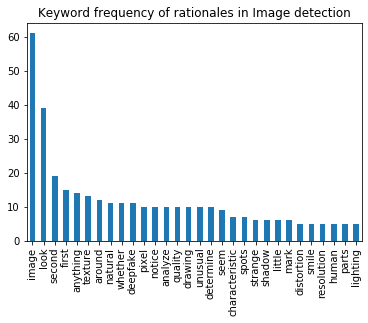

In [136]:
df = pd.DataFrame({'freq': image_data_full})
df.groupby('freq', as_index=False).size()
#display(df)
pp = df.freq.str.split(expand=True).stack().value_counts()
#display(pp[:25])
pp = pp[:30]
print(type(pp))
#pp.groupby('freq', as_index=False).size().plot(kind='bar')
#plt.show()
#p = plt.plot(pp.values, pp.index)
pp.plot.bar(rot=90, title="Keyword frequency of rationales in Image detection")
plt.show()

<class 'pandas.core.series.Series'>


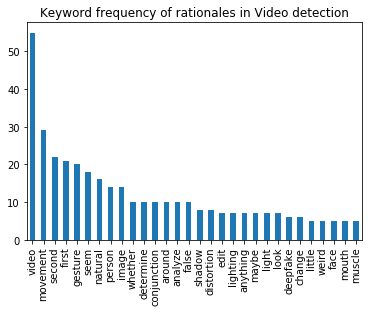

In [137]:
df = pd.DataFrame({'freq': video_data_full})
df.groupby('freq', as_index=False).size()
#display(df)
pp = df.freq.str.split(expand=True).stack().value_counts()
#display(pp[:25])
pp = pp[:30]
print(type(pp))
#pp.groupby('freq', as_index=False).size().plot(kind='bar')
#plt.show()
#p = plt.plot(pp.values, pp.index)
pp.plot.bar(rot=90, title="Keyword frequency of rationales in Video detection")
plt.show()

In [134]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
#pyLDAvis.show(lda_display)

C:\Users\adity\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
